In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import time
import timeit
import json

os.environ["DGLBACKEND"] = "pytorch"

from dgl import from_networkx
import networkx as nx


import torch as th
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import itertools

from src.models import GRAPHSAGE, GAT, GCN
from src.dataset.dataset_info import datasets
from src.graph.graph_measures import calculate_graph_measures

# datasets = {dataset.name: dataset for dataset in datasets_list}

num_epochs = 100
batch_size = 128
learning_rate = 0.001
LAMBD_1 = 0.0001
LAMBD_2 = 0.001


In [2]:
name = "cic_ids_2017_5_percent"
# name = "cic_ton_iot_5_percent"
# name = "cic_ton_iot"
# name = "cic_ids_2017"
# name = "nf_bot_iot"
# name = "edge_iiot"
# name = "nf_cse_cic_ids2018"
# name = "nf_bot_iotv2"
# name = "nf_uq_nids"
# name = "x_iiot"
# name = "cic_ton_iot_modified"
# name = "nf_ton_iotv2_modified"
# name = "ccd_inid_modified"
# name = "nf_uq_nids_modified"

dataset = datasets[name]

In [3]:
results_final = {}

results_final["name"] = name
results_final["configuration"] = {
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    # "early_stopping": early_stopping,
    # "pca": pca,
    # "digraph_centralities": digraph_centralities,
    # "multi_graph_centralities": multi_graph_centralities,
    # "learning_rate": learning_rate,
    # "LAMBD_1": LAMBD_1,
    # "LAMBD_2": LAMBD_2,
    # "cfg": OmegaConf.to_container(cfg)
}

results_final["accuracy"] = {}

    
results_final["gcn"] = {}
# results_final["gcn_res"] = {}

results_final["graph_sage"] = {}
# results_final["e_graph_sage_res"] = {}

results_final["gat"] = {}
# results_final["e_gat_res"] = {}


results_final

{'name': 'cic_ids_2017_5_percent',
 'configuration': {'num_epochs': 100, 'batch_size': 128},
 'accuracy': {},
 'gcn': {},
 'graph_sage': {},
 'gat': {}}

In [4]:
dtime = time.strftime("%Y%m%d-%H%M%S")
dtime

'20240929-212117'

In [39]:
results_folder_path = "results"
results_folder_path1 = os.path.join(results_folder_path, name)
results_folder_path2 = os.path.join(results_folder_path1, "line_graph")
folder_path = os.path.join(results_folder_path2, dtime)
confusion_matrices_path = os.path.join(folder_path, "confusion_matrices")
os.makedirs(confusion_matrices_path, exist_ok=True)
# os.makedirs(confusion_matrices_path, exist_ok=True)

In [6]:
dataset_folder_path_train = os.path.join("datasets", name, "line_graph", "training")
dataset_folder_path_test = os.path.join("datasets", name, "line_graph", "testing")

In [7]:
training_graphs = []
for file in os.listdir(dataset_folder_path_train):
    # print(f"==>> file: {os.path.join(dataset_folder_path_train, file)}")
    with open(os.path.join(dataset_folder_path_train, file), "rb") as f:
        G = pickle.load(f)
        # print(list(G.nodes(data=True))[0])
        G = from_networkx(G,node_attrs=['h',dataset.label_col, "index"])
        node_label = G.ndata[dataset.label_col]
        # if len(node_label.unique()) > 1:
        #     print(f"==>> node_label.unique(): {len(node_label.unique())}")
            
        training_graphs.append(G)

        # break
        
len(training_graphs)

==>> file: datasets\cic_ids_2017_5_percent\line_graph\training\graph_0.pkl
==>> file: datasets\cic_ids_2017_5_percent\line_graph\training\graph_1.pkl
==>> file: datasets\cic_ids_2017_5_percent\line_graph\training\graph_10.pkl
==>> file: datasets\cic_ids_2017_5_percent\line_graph\training\graph_11.pkl
==>> file: datasets\cic_ids_2017_5_percent\line_graph\training\graph_12.pkl
==>> file: datasets\cic_ids_2017_5_percent\line_graph\training\graph_13.pkl
==>> file: datasets\cic_ids_2017_5_percent\line_graph\training\graph_14.pkl
==>> node_label.unique(): 2
==>> file: datasets\cic_ids_2017_5_percent\line_graph\training\graph_15.pkl
==>> node_label.unique(): 2
==>> file: datasets\cic_ids_2017_5_percent\line_graph\training\graph_16.pkl
==>> node_label.unique(): 2
==>> file: datasets\cic_ids_2017_5_percent\line_graph\training\graph_17.pkl
==>> file: datasets\cic_ids_2017_5_percent\line_graph\training\graph_18.pkl
==>> file: datasets\cic_ids_2017_5_percent\line_graph\training\graph_19.pkl
==>> n

56

In [8]:
def compute_accuracy(pred, labels):
    return (pred.round() == labels).float().mean().item()

In [9]:
G0 = training_graphs[0]
features_number = G.ndata['h'].shape[1]

In [10]:
def train_gnn(model, graphs):
        
    opt = th.optim.Adam(model.parameters())
    criterion = nn.BCELoss()
    # criterion = nn.CrossEntropyLoss()

    for epoch in range(1,num_epochs):
        predictions = []
        labels = []
        for G in graphs:
            # class_weights = class_weight.compute_class_weight('balanced',
            #                                          classes = np.unique(node_label.cpu().numpy()),
            #                                          y = node_label.cpu().numpy())
            # class_weights = th.FloatTensor(class_weights)
            # criterion = nn.CrossEntropyLoss(weight = class_weights)
            # criterion = nn.BCELoss(weight = class_weights)
            
            node_features = G.ndata['h']
            node_label = G.ndata[dataset.label_col].float()
            # print(f"==>> node_label.unique(): {node_label.unique()}")
            # node_index = G.ndata["index"]
            
            #     pred = model(G, node_features,edge_features).cuda()
            pred = model(G, node_features).squeeze(1)
            predictions.append(pred)
            labels.append(node_label)
            
        predictions_tensor = th.cat(predictions, dim=0)
        labels_tensor = th.cat(labels, dim=0)
        loss = criterion(predictions_tensor, labels_tensor)
        opt.zero_grad()
        loss.backward()
        opt.step()
        # print('Training acc:', compute_accuracy(pred, node_label))
        print('Epoch:', epoch ,' Training acc:', compute_accuracy(pred, node_label))
    return model


### Training EGCN

In [11]:
model = GCN(features_number)
model_gcn = train_gnn(model, training_graphs)

Epoch: 1  Training acc: 0.6144999861717224
Epoch: 2  Training acc: 0.6294999718666077
Epoch: 3  Training acc: 0.6589999794960022
Epoch: 4  Training acc: 0.6990000009536743
Epoch: 5  Training acc: 0.7179999947547913
Epoch: 6  Training acc: 0.6744999885559082
Epoch: 7  Training acc: 0.7475000023841858
Epoch: 8  Training acc: 0.7335000038146973
Epoch: 9  Training acc: 0.7515000104904175
Epoch: 10  Training acc: 0.7245000004768372
Epoch: 11  Training acc: 0.7670000195503235
Epoch: 12  Training acc: 0.7910000085830688
Epoch: 13  Training acc: 0.7979999780654907
Epoch: 14  Training acc: 0.8169999718666077
Epoch: 15  Training acc: 0.8224999904632568
Epoch: 16  Training acc: 0.8535000085830688
Epoch: 17  Training acc: 0.8554999828338623
Epoch: 18  Training acc: 0.8560000061988831
Epoch: 19  Training acc: 0.8914999961853027
Epoch: 20  Training acc: 0.8725000023841858
Epoch: 21  Training acc: 0.8939999938011169
Epoch: 22  Training acc: 0.9014999866485596
Epoch: 23  Training acc: 0.91699999570846

### Training EGraphSage 

In [12]:
# (``mean``, ``gcn``, ``pool``, ``lstm``)
model = GRAPHSAGE(features_number, aggregator_type = "lstm")
model_sage = train_gnn(model, training_graphs)

### Training EGAT

In [13]:
model = GAT(features_number)
model_gat = train_gnn(model, training_graphs)

# Testing

In [23]:
testing_graphs = []
for file in os.listdir(dataset_folder_path_test):
    # print(f"==>> file: {os.path.join(dataset_folder_path_test, file)}")
    with open(os.path.join(dataset_folder_path_test, file), "rb") as f:
        G = pickle.load(f)
        # print(list(G.nodes(data=True))[0])
        G = from_networkx(G,node_attrs=['h',dataset.label_col, "index"])
        node_label = G.ndata[dataset.label_col]
        # if len(node_label.unique()) > 1:
        #     print(f"==>> node_label.unique(): {len(node_label.unique())}")
            
        testing_graphs.append(G)

        # break
        
len(testing_graphs)

==>> file: datasets\cic_ids_2017_5_percent\line_graph\testing\graph_56.pkl
==>> node_label.unique(): 2
==>> file: datasets\cic_ids_2017_5_percent\line_graph\testing\graph_57.pkl
==>> node_label.unique(): 2
==>> file: datasets\cic_ids_2017_5_percent\line_graph\testing\graph_58.pkl
==>> node_label.unique(): 2
==>> file: datasets\cic_ids_2017_5_percent\line_graph\testing\graph_59.pkl
==>> node_label.unique(): 2
==>> file: datasets\cic_ids_2017_5_percent\line_graph\testing\graph_60.pkl
==>> node_label.unique(): 2
==>> file: datasets\cic_ids_2017_5_percent\line_graph\testing\graph_61.pkl
==>> node_label.unique(): 2
==>> file: datasets\cic_ids_2017_5_percent\line_graph\testing\graph_62.pkl
==>> node_label.unique(): 2
==>> file: datasets\cic_ids_2017_5_percent\line_graph\testing\graph_63.pkl
==>> node_label.unique(): 2
==>> file: datasets\cic_ids_2017_5_percent\line_graph\testing\graph_64.pkl
==>> node_label.unique(): 2
==>> file: datasets\cic_ids_2017_5_percent\line_graph\testing\graph_65.pk

15

In [29]:
def test_gnn(model, graphs):
    predictions = []
    labels = []
    start_time = timeit.default_timer()
    for G in graphs:
        
        node_features_test  = G.ndata['h']
        node_label_test  = G.ndata[dataset.label_col].float()
        test_pred = model(G, node_features_test).squeeze(1)
        predictions.append(test_pred)
        # print(f"==>> predictions: {predictions}")
        labels.append(node_label_test)
        # print(f"==>> labels: {labels}")
    
    elapsed = timeit.default_timer() - start_time
    print(str(elapsed) + ' seconds')

    predictions_tensor = th.cat(predictions, dim=0).round().detach().numpy()
    print(f"==>> predictions_tensor: {predictions_tensor}")
    labels_tensor = th.cat(labels, dim=0)
    print(f"==>> labels_tensor: {labels_tensor}")

    return (labels_tensor, predictions_tensor)


In [30]:

def calculate_FPR_FNR(cm):
 
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
 
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
 
    return FPR, FNR

In [31]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          file_path = None):
    

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    if file_path:
        plt.savefig(file_path)
    plt.show()

### Testing EGCN

In [34]:
actual, test_pred = test_gnn(model_gcn, testing_graphs)

actual = ["Normal" if i == 0 else "Attack" for i in actual]
test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

2.541561200050637 seconds
==>> predictions_tensor: [0. 0. 0. ... 0. 0. 0.]
==>> labels_tensor: tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [35]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

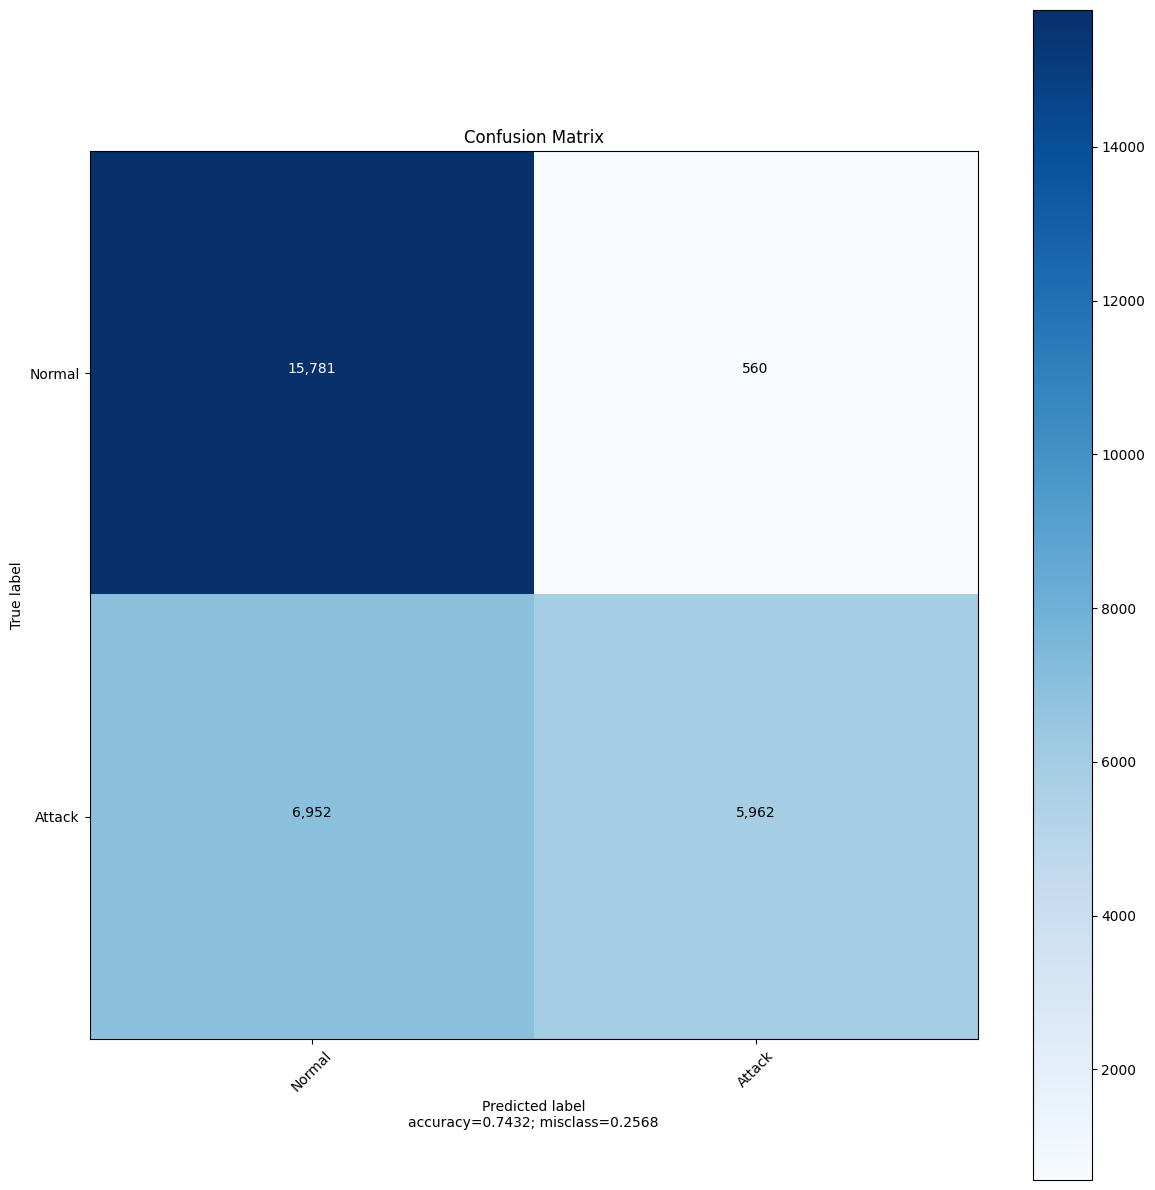

In [40]:
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/gcn.png')

In [41]:
FPR, FNR = calculate_FPR_FNR(cm)

In [43]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["gcn"]["classification_report"] = cr
results_final["gcn"]["FPR"] = FPR
results_final["gcn"]["FNR"] = FNR
results_final["accuracy"]["gcn"] = cr["accuracy"]

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9141    0.4617    0.6135     12914
      Normal     0.6942    0.9657    0.8077     16341

    accuracy                         0.7432     29255
   macro avg     0.8042    0.7137    0.7106     29255
weighted avg     0.7913    0.7432    0.7220     29255



### Testing EGraphSage

In [44]:
actual, test_pred = test_gnn(model_sage, testing_graphs)

actual = ["Normal" if i == 0 else "Attack" for i in actual]
test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

In [45]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

In [46]:
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_graph_sage.png')

In [47]:
FPR, FNR = calculate_FPR_FNR(cm)

In [48]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["graph_sage"]["classification_report"] = cr
results_final["graph_sage"]["FPR"] = FPR
results_final["graph_sage"]["FNR"] = FNR
results_final["accuracy"]["graph_sage"] = cr["accuracy"]

print(classification_report(actual, test_pred, digits=4))

### Testing EGAT

In [49]:
actual, test_pred = test_gnn(model_gat, testing_graphs)

actual = ["Normal" if i == 0 else "Attack" for i in actual]
test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

In [50]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

In [51]:
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_gat.png')

In [52]:
FPR, FNR = calculate_FPR_FNR(cm)

In [53]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["gat"]["classification_report"] = cr
results_final["gat"]["FPR"] = FPR
results_final["gat"]["FNR"] = FNR
results_final["accuracy"]["gat"] = cr["accuracy"]

print(classification_report(actual, test_pred, digits=4))

### Saving results

In [54]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

filename = (folder_path + '/results.json'.format(dtime))
outfile = open(filename, 'w')
outfile.writelines(json.dumps(results_final, cls=NumpyEncoder))
outfile.close()